### Imports

In [ ]:
from IPython.core.debugger import set_trace

#%load_ext nb_black

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import time

plt.style.use(style="dark_background")

In [2]:
SENTIMENT_LABELLED_DATA_FILEPATH = '..\Data\Sentiment Analysis Dataset.csv'
DATA_PREPROCESSING_FILEPATH = '../Data Preprocessed'

TOKENIZER_OUTPUT_FILEPATH = 'tokenizer_100K.pickle'
MODEL_OUTPUT_FILEPATH = 'model_100K_glove'
# MODEL_OUTPUT_FILEPATH = 'model_100K_glove'
MODEL_OUTPUT_FILEPATH = 'model_100K_glove_91_X'

#### Dataset Import

In [3]:
txt_data = pd.read_csv(SENTIMENT_LABELLED_DATA_FILEPATH , sep='|', names=['col1'])

#split data into columns with ','
txt_data = txt_data.col1.str.split(',',  3, expand=True)
txt_data.columns = list(txt_data.iloc[0])
txt_data = txt_data.drop(0)
txt_data.index = np.subtract(txt_data.index, 1)


In [4]:
dataset = pd.concat([txt_data['SentimentText'], txt_data['Sentiment']], axis = 1)
dataset.columns = ['text', 'target']

In [5]:
# Dataset Inspection
print(dataset.info(verbose=True))
dataset.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1577838 entries, 0 to 1577837
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   text    1577838 non-null  object
 1   target  1577838 non-null  object
dtypes: object(2)
memory usage: 36.1+ MB
None


,text,target
0,is so sad for my APL frie...,0
1,I missed the New Moon trail...,0
2,omg its already 7:30 :O,1
3,.. Omgaga. Im sooo im gunna CRy. I'...,0
4,i think mi bf is cheating on me!!! ...,0


In [6]:
#suffle
dataset = dataset.sample(frac = 1)
dataset

,text,target
969154,is hoping the sunburn eases up soon..a few bli...,0
1440799,I have 500 updates now! WEEEEEEE. hahahaha,1
1277006,Twitter blocked me..said I sent out too many t...,0
779736,home sweet home for the time being,1
627404,Cell service is going in and out... So hopeful...,0
...,...,...
1159488,"""@punker616 most of my friends had a c-section...",1
424150,@Seeshush You're quite welcome,1
337112,"""@LiLish okay, awesome! yeah, new rims suck!!...",0
1548715,Thunder and lightning very very frightening...,0


#### NLP Imports

In [7]:
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.append(DATA_PREPROCESSING_FILEPATH)
from data_preprocess import *

import pickle

In [8]:
text = NLP_preprocess(dataset)
text.preprocess_data()

text.set_tokenizer()
import pickle

# saving
# with open(TOKENIZER_OUTPUT_FILEPATH, 'wb') as handle:
#     pickle.dump(text.tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Preprocessing

#### Train / Test Split - Tokenization - Padding

In [15]:
train_dataset = dataset[:1000000]
train_labels = train_dataset.target.astype(float)
train_padded = text.tokenize_and_pad(train_dataset, train = True)
print(train_padded)
# saving
# with open(TOKENIZER_OUTPUT_FILEPATH, 'wb') as handle:
#     pickle.dump(text.tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

[[   488   1682  33684 ...      0      0      0]
 [  2331    685  20813 ...      0      0      0]
 [    43   1618 117013 ...      0      0      0]
 ...
 [     1    255     81 ...      0      0      0]
 [  1381   2581  13126 ...      0      0      0]
 [   184   5024    199 ...      0      0      0]]


In [16]:
text.set_embedding_matrix()

In [17]:
pd.DataFrame(text.embedding_matrix).info


<bound method DataFrame.info of               0         1         2        3        4        5        6   \
0       0.000000  0.000000  0.000000  0.00000  0.00000  0.00000  0.00000   
1       0.000000  0.000000  0.000000  0.00000  0.00000  0.00000  0.00000   
2      -0.673910  0.544500 -0.448680  0.16763 -0.22777  0.56469  0.23045   
3       0.091552  0.093336 -0.028113  0.36990  0.18956  0.43191  0.10266   
4      -0.159680 -0.369660  0.237610 -0.12432  0.67826  0.11184  0.30487   
...          ...       ...       ...      ...      ...      ...      ...   
783276  0.000000  0.000000  0.000000  0.00000  0.00000  0.00000  0.00000   
783277  0.000000  0.000000  0.000000  0.00000  0.00000  0.00000  0.00000   
783278  0.000000  0.000000  0.000000  0.00000  0.00000  0.00000  0.00000   
783279  0.000000  0.000000  0.000000  0.00000  0.00000  0.00000  0.00000   
783280  0.000000  0.000000  0.000000  0.00000  0.00000  0.00000  0.00000   

             7        8         9   ...       90       

In [18]:
# Test dataset preporcess
test_dataset = dataset[:200000]
test_labels = test_dataset.target.astype(float)
test_padded = text.tokenize_and_pad(test_dataset, train = False)
print(test_padded)

[[   488   1682  33684 ...      0      0      0]
 [  2331    685  20813 ...      0      0      0]
 [    43   1618 117013 ...      0      0      0]
 ...
 [   178    175    452 ...      0      0      0]
 [ 11816   4229     29 ...      0      0      0]
 [  1273     11      0 ...      0      0      0]]


### Model

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.initializers import Constant
from tensorflow.keras.optimizers import Adam

model = Sequential()

# trainable = False
#bidirectional

#Glove
model.add(
    Embedding(
        text.num_words,
        100,
        embeddings_initializer = Constant(text.embedding_matrix),
        input_length = text.max_length,
        trainable = False,
    )
)

#basic
# for i in range(0,200):
# #model.add(Embedding(text.num_words, 8, input_length=text.max_length))
#     model.add(Dense(1000, activation='relu'))
model.add(LSTM(100, dropout=0.1))
model.add(Dense(1, activation="sigmoid"))

optimizer = Adam(learning_rate=3e-4)

model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 100)           78328100  
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 78,408,601
Trainable params: 80,501
Non-trainable params: 78,328,100
_________________________________________________________________


In [22]:
history = model.fit(
    train_padded, train_labels, epochs=5, validation_data=(test_padded, test_labels),
)

Epoch 1/5
49308/49308 [==============================] - 229s 5ms/step - loss: 0.4756 - accuracy: 0.7715 - val_loss: 0.4560 - val_accuracy: 0.7844
Epoch 2/5
49308/49308 [==============================] - 210s 4ms/step - loss: 0.4505 - accuracy: 0.7866 - val_loss: 0.4373 - val_accuracy: 0.7950
Epoch 3/5
49308/49308 [==============================] - 210s 4ms/step - loss: 0.4506 - accuracy: 0.7876 - val_loss: 0.4381 - val_accuracy: 0.7944
Epoch 4/5
49308/49308 [==============================] - 214s 4ms/step - loss: 0.4428 - accuracy: 0.7918 - val_loss: 0.4338 - val_accuracy: 0.7958
Epoch 5/5
49308/49308 [==============================] - 220s 4ms/step - loss: 0.4338 - accuracy: 0.7967 - val_loss: 0.4221 - val_accuracy: 0.8037


In [ ]:
#model.save(MODEL_OUTPUT_FILEPATH)

#### Sample evaluation

In [ ]:
import random
#test_neg = random.choice(neg.values)
i = random.choice(test_dataset.index)
if test_dataset.loc[i]['target'] == '0':
    print('negative: ', test_dataset.loc[i]['text'])
else:
    print('positive: ', test_dataset.loc[i]['text'])
test_sequences = text.tokenizer.texts_to_sequences([test_dataset.loc[i]['text']])
test_padded2 = pad_sequences(
    test_sequences, maxlen=text.max_length, padding="post", truncating="post"
)
model.predict(test_padded2)

### Analytics

#### ROC graphs

In [76]:
from sklearn.metrics import roc_curve
y_pred_keras = model.predict(test_padded).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_labels, y_pred_keras)

In [77]:
#inverse the labels to get the negative rates
inversed_y_pred_keras = pd.DataFrame(y_pred_keras).apply(lambda x: abs(x-1))
#false positivee is true negative here and true positive is false negative
tnr_keras, fnr_keras, thresholds_keras2 = roc_curve(test_labels, inversed_y_pred_keras)

In [106]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)
auc_keras2 = auc(fnr_keras, tnr_keras)

In [107]:
from sklearn.ensemble import RandomForestClassifier
# Supervised transformation based on random forests
rf = RandomForestClassifier(max_depth=3, n_estimators=10)
rf.fit(train_padded, train_labels)

y_pred_rf = rf.predict_proba(test_padded)[:, 1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(test_labels, y_pred_rf)
auc_rf = auc(fpr_rf, tpr_rf)

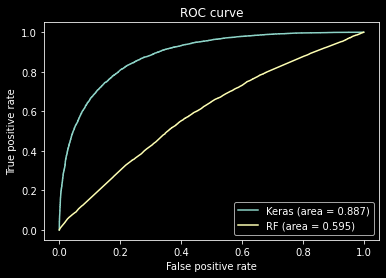

In [74]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [113]:
test_labels

969154     0.0
1440799    1.0
1277006    0.0
779736     1.0
627404     0.0
          ... 
1039860    1.0
58323      1.0
1061774    1.0
682557     1.0
1004894    1.0
Name: target, Length: 20000, dtype: float64

#### Confusion Matrix

In [156]:
df = pd.DataFrame(y_pred_keras, columns = ["predicted"])
#make predictions either 0 or 1
df["predicted"] = df["predicted"].apply(lambda x: round(x))
test_labels.index = df.index
df = pd.concat([df,test_labels], axis =1)
df

,predicted,target
0,0,0.0
1,1,1.0
2,0,0.0
3,1,1.0
4,1,0.0
...,...,...
19995,1,1.0
19996,1,1.0
19997,1,1.0
19998,1,1.0


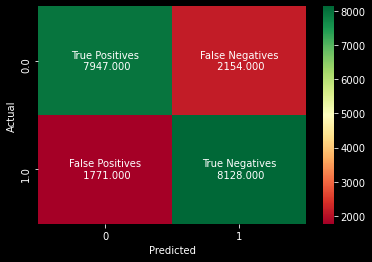

In [160]:
import seaborn as sn
confusion_matrix = pd.crosstab(df['target'], df['predicted'], rownames=['Actual'], colnames=['Predicted'])
strings = strings = np.asarray([['True Positives\n', 'False Negatives\n'],
                                ['False Positives\n', 'True Negatives\n']])
labels = (np.asarray(["{0} {1:.3f}".format(string, value)
                      for string, value in zip(strings.flatten(),
                                               confusion_matrix.values.flatten())])
         ).reshape(2, 2)

fig, ax = plt.subplots()
sn.heatmap(confusion_matrix, annot=labels, fmt="", cmap='RdYlGn', ax=ax)
plt.show()


In [165]:
tp = confusion_matrix[0][0]
fn = confusion_matrix[1][0]

tn = confusion_matrix[1][1]
fp = confusion_matrix[0][1]

sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)

print("Sensitivity: ", sensitivity)
print("Specificity: ", specificity)

Sensitivity:  0.7867537867537867
Specificity:  0.8210930397009799
